<a href="https://colab.research.google.com/github/patdring/StockTrendForecaster/blob/main/StockPriceXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 40000 candidates, totalling 120000 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.1}


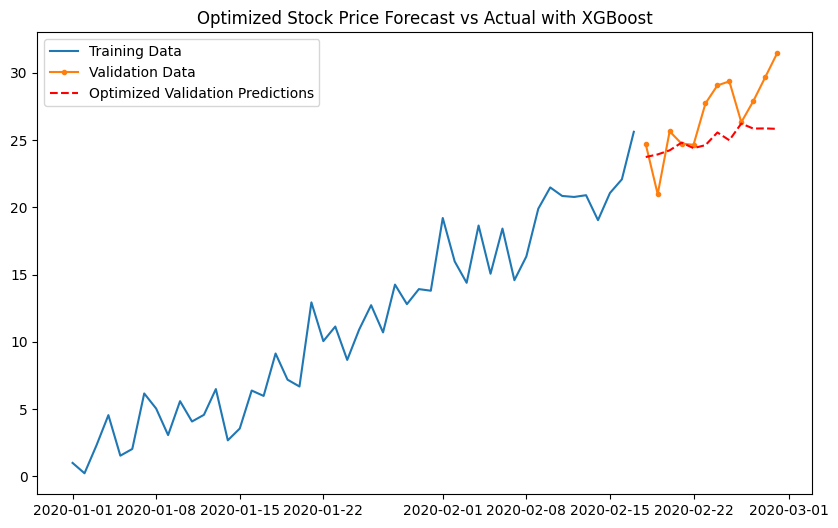

In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import datetime

# Generate simulated data
np.random.seed(42)
num_data_points = 60
dates = pd.date_range(start='2020-01-01', periods=num_data_points, freq='D')
stock_prices = np.random.randn(num_data_points) * 2 + np.arange(num_data_points) * 0.5
economic_data = stock_prices * 0.3 + np.random.randn(num_data_points) * 0.5
temperature_data = stock_prices * 0.1 + 20 + np.random.randn(num_data_points) * 5
sentiment_data = stock_prices * 0.05 + np.random.uniform(-1, 1, num_data_points)

# Prepare the data
df = pd.DataFrame({
    'day': dates.day,
    'month': dates.month,
    'year': dates.year,
    'economic': economic_data,
    'temperature': temperature_data,
    'sentiment': sentiment_data,
    'y': stock_prices
})

# Split data into training and validation sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
val_data = df.iloc[train_size:]

# Prepare X and y
X_train = train_data.drop(['y'], axis=1)
y_train = train_data['y']
X_val = val_data.drop(['y'], axis=1)
y_val = val_data['y']

# Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 1000],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train a new model with the best parameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions with the best model
val_predictions_optimized = best_xgb_model.predict(X_val)

# Plot the optimized forecast along with actual data
plt.figure(figsize=(10, 6))
plt.plot(dates[:train_size], y_train, label='Training Data')
plt.plot(dates[train_size:], y_val, label='Validation Data', marker='.')
plt.plot(dates[train_size:], val_predictions_optimized, label='Optimized Validation Predictions', linestyle='--', color='red')
plt.title('Optimized Stock Price Forecast vs Actual with XGBoost')
plt.legend()
plt.show()
